<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/11_Flower_imagedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Load image with tf.data**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exist in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

**### Download and inspect the dataset**

**Reteieve the images**
Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You have alraedy create an archive of creative-commons licesnse flower photos to use initially.


In [ ]:
import pathlib

data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos',untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/root/.keras/datasets/flower_photos


After downloading 218MB, you should now have a copy of the flower photos available:

In [ ]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/roses


In [ ]:
import random
all_image_paths = list(data_root.glob('*/*'))
print(all_image_paths)
all_image_paths = [str(path) for path in all_image_paths]
print(all_image_paths)
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

[PosixPath('/root/.keras/datasets/flower_photos/dandelion/16716172029_2166d8717f_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/14457225751_645a3784fd_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/253622055_d72964a7fd_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/7719263062_3c8a307a5d.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/5598591979_ed9af1b3e9_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/141935731_d26d600f4f_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/1193386857_3ae53574f2_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/11768468623_9399b5111b_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/4893356345_24d67eff9f_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/8929523512_c87897b84e.jpg'), PosixPath('/root/.keras/datasets/flower_photos/dandelion/19626311985_58f1a79da3.jpg'), PosixPath('/root/.keras/datasets/fl

3670

In [ ]:
all_image_paths[:10]

['/root/.keras/datasets/flower_photos/tulips/13910544560_9140dd547e.jpg',
 '/root/.keras/datasets/flower_photos/daisy/3975010332_3209f9f447_m.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/2767688889_b176b0c3fb.jpg',
 '/root/.keras/datasets/flower_photos/daisy/3758221664_b19116d61f.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/15745084272_36402f5ee6_n.jpg',
 '/root/.keras/datasets/flower_photos/daisy/1265350143_6e2b276ec9.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/6042014768_b57f0bfc79_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/5740633858_8fd54c23c9_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/2976723295_b16ab04231.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/8723679596_391a724d4f_m.jpg']

### **Inspect the images**
 Now let's have a quick look at a couple of the images, so you know what you are dealing with:

In [ ]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY ') for line in attributions]
attributions = dict(attributions)

In [ ]:
import IPython.display as display

def caption_image(image_path):
  image_rel = pathlib.Path(image_path).relative_to(data_root)
  return "Image (CC BY 2.0)" + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])


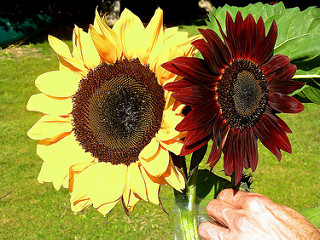

Image (CC BY 2.0)by Deb Nystrom



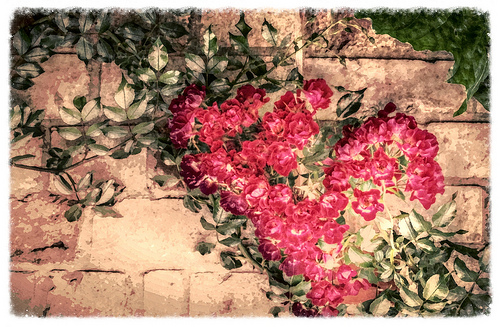

Image (CC BY 2.0)by Julie anne Johnson



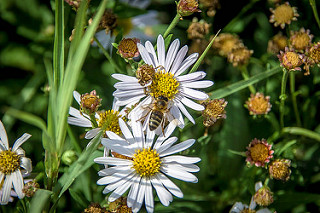

Image (CC BY 2.0)by Jamiecat *



In [ ]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

**Determine the label for each image**

List the available labels:

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
#Assign an index to each lables:

label_to_index = dict((name,index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
#Create a list of every file, and its label index:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10] ) 

First 10 labels indices:  [4, 0, 3, 0, 3, 0, 3, 1, 2, 1]


### **Load and formate the image**

TensorFlow includes all the tools you need to load and process images:

In [ ]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/flower_photos/tulips/13910544560_9140dd547e.jpg'

In [ ]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


In [ ]:
#Resize it for your model:

img_final = tf.image.resize(img_tensor,[192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.07213063
1.0


Wrap up these up in simple functions for later:

In [ ]:
def preprocessing_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192,192])
  image /= 255.0 # normalize to [0,1] range

  return image

In [ ]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocessing_image(image)

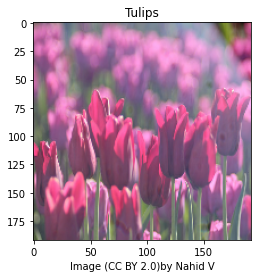

In [ ]:
import matplotlib.pylab as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())
print()

## **Building a tf.data.Dataset**

**A dataset of images**

The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.
Slicing the array of strings,results in a dataset of strings:

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

The shapes and types describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

In [ ]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


Now create a new dataset that loads and formate images on the fly by mapping preprocess_image over the dataset of paths.

In [ ]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

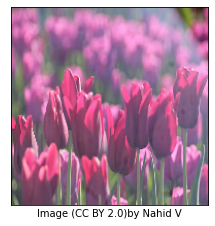

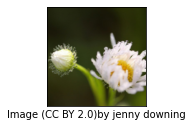

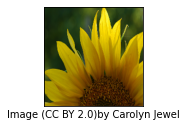

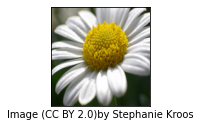

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

**A dataset of(image, labels) pairs**

Using the same from_tensor_slices method you can build a dataset of labels:

In [ ]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [ ]:
for labels in label_ds.take(10):
  print(label_names[labels.numpy()])

tulips
daisy
sunflowers
daisy
sunflowers
daisy
sunflowers
dandelion
roses
dandelion


In [ ]:
#Since the datasets are in the same order you can just zip them together to get a dataset of(image, labels) pairs:

image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

In [ ]:
#The new dataset's shapes and types are tuples of shapes and types as well, describing each field:

print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


Note: When you have arrays like all_image_labels and all_image_paths as alternative to tf.data.dataset.Dataset.zip is to slice the pair of arrays.

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_image_from_path_label(path,label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_image_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

**Basic methods for training**

To train a model with this dataset you will want the data:
*   To be well shuffled.
*   To be batched.
*   To repeat forever.
*   Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [ ]:
BATCH_SIZE = 32

#Setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

#prefetch lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size = AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

**Pipe the dataset to a model**

Fetch a copy of Mobilenet v2 from tf.keras.applications.

This will be used for a simple transfer learing example.

Set the MobileNet weight to be non-trainable:

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192,192,3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


This model expects its input to be normalozed to the [-1, 1] range:
    
    help(keras_applications.mobilenet_v2.preprocess_input)
    ...

    This function applies the "Inception" preprocessing which concerts
    the RGB values from [0, 255] to [-1, 1]


Before you pass the input to the MobileNet model, you need to convert it from a range of [0,1] to [-1,1]:

In [ ]:
def change_range(image,label):
  return 2*image-1, label

keras_ds =ds.map(change_range)

The MobileNet retuerns a 6x6 spatial grid of feature for each image.

pass it a batch of images to see:

In [ ]:
image_batch, label_batch = next(iter(keras_ds))

In [ ]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch)

tf.Tensor(
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         1.0359424
    0.        ]
   [0.         0.         0.         ... 0.         1.3647854
    0.        ]]

  [[0.         0.59629625 1.1015091  ... 0.         0.
    0.        ]
   [0.         1.0500305  0.         ... 0.         0.
    2.6287785 ]
   [0.         0.20038503 0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         1.4065714
    0.        ]
   [0.         0.         0.         ... 0.         1.6444705
    0.        ]]

  [[0.         2.1555367  1.2798537  ... 0.         0.
    0.8118638 ]
   [0.         6.         0.      

Build a model wrapped around MobileNet and use tf.keras.layer.GlobalAveragePooling2D to average over those space dimensions before thr output tf.keras.layer.Dense layer:

In [ ]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')                           
])

In [ ]:
logit_batch = model(image_batch).numpy()

print("min logit: ", logit_batch.min())
print("max logit: ", logit_batch.max())
print()

print("Shape: ", logit_batch.shape)

min logit:  0.005914462
max logit:  0.86290157

Shape:  (32, 5)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics = ["accuracy"])

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [ ]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 12s 728ms/step - loss: 2.0576 - accuracy: 0.1615
